In [2]:
import scipy.io as sio
from scipy.signal import welch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from functools import reduce
import pandas as pd
import pylab
from glob import glob
from functools import partial
from math import ceil
from os.path import split, splitext

%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

Calculamos la máxima frecuencia de sampleo necesaria para no perder información

In [3]:
def loadSubject(filename):
    return sio.loadmat(filename)['data']

def allSubjects():
    return sorted(glob('dataset/*'))

data = loadSubject('dataset/P01.mat')
# epoch, electrodo, muestra
cant_muestras = len(data[0, 0])
cant_electrodos = len(data[0])
long_epoch = 0.8  # segundos
nfft = 2047
longitud_de_poderes = ceil(nfft / 2)
bandas = [0, 4, 8, 13, 30, 45]
nombre_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Redefino welch para que siempre tenga el mismo nfft
welch_eeg = partial(welch, fs=90, nfft=nfft)

In [4]:
electrodos = [8, 44, 80, 131, 185]

frecuencias, _ = welch(data[0, 0], fs=90)

def heatmap(desde=0, hasta=cant_muestras):
    epochs = []
    for epoch in range(len(data)):
        poderes_espectrales = []
        for electrodo in electrodos:
            frecuencias, poder_espectral = welch_eeg(data[epoch, electrodo][desde:hasta])
            poderes_espectrales.append(np.array(poder_espectral))

        matriz = np.stack(poderes_espectrales)
        medias_de_poderes_espectrales = np.mean(matriz, axis=0)
        epochs.append(np.log(medias_de_poderes_espectrales))

    sns.heatmap(np.array(epochs).transpose())

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color como en el ejemplo:

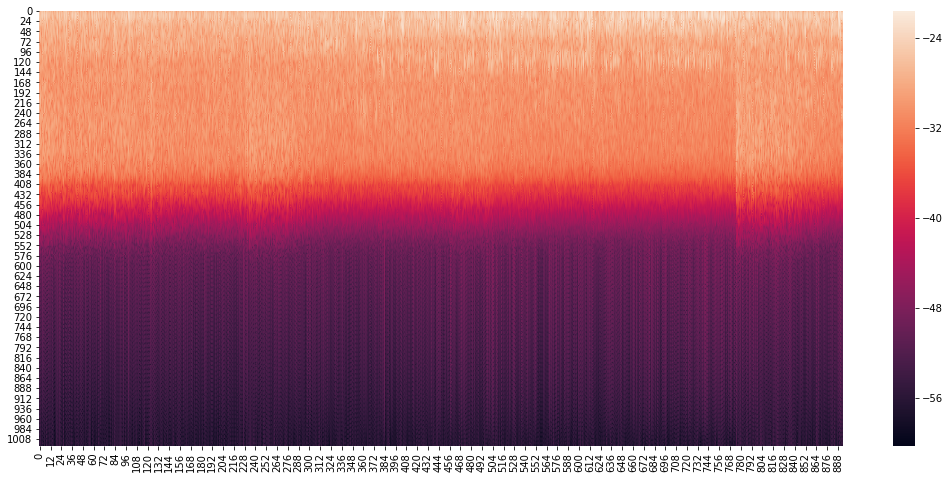

In [20]:
heatmap()

a.2) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal, como en el ejemplo:

In [ ]:
def potencia_media_por_frecuencia(electrodo=0):
    epochs = []
    for epoch in range(len(data)):
        frecuencias, poder_espectral = welch_eeg(data[epoch, electrodo])
        epochs.append(poder_espectral)
    
    # matriz donde las filas son epochs, las columnas frecuencias y los valores poderes espectrales
    matriz = np.stack(epochs)
    medias_de_poderes_espectrales = np.mean(matriz, axis=0)
    plt.plot(frecuencias, medias_de_poderes_espectrales)

for electrodo in range(cant_electrodos):
    potencia_media_por_frecuencia(electrodo)
    
plt.xlim(0, 12)    # set the xlim to xmin, xmax

Generamos una función auxiliar para binnear las frecuencias y la testeamos

In [5]:
def getBanda(frecuencia):
    """ [0, 4, 8, 13, 30, 45]  # Delta, Theta, Alpha, Beta, Gamma """
    res = 0
    for indice, lim_izq in enumerate(bandas):
        if frecuencia >= lim_izq:
            res = indice
        else:
            break
    return res

assert getBanda(1) == 0
assert getBanda(6) == 1
assert getBanda(10) == 2
assert getBanda(15) == 3
assert getBanda(33) == 4
assert getBanda(50) == 5

b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

In [21]:
barwidth = 1 / len(allSubjects())

bins_por_sujeto = {}
# for index, filename in enumerate(['dataset/S01.mat', 'dataset/P01.mat']):
for index, filename in enumerate(allSubjects()):
    poderes_por_sujeto = np.zeros(longitud_de_poderes)
    bins = np.zeros(len(bandas))
    cantIteraciones = 0
    subject_data = loadSubject(filename)  # epoch, electrodo, muestra
    
    for epoch in subject_data:
        for num_electrodo in electrodos:
            electrodo = epoch[num_electrodo]
            frecuencias, poder_espectral = welch_eeg(electrodo)
            poderes_por_sujeto += poder_espectral
            cantIteraciones += 1

    # Calculamos el promedio de los poderes espectrales para un sujeto dado, todos los epochs y los
    # electrodos indicados.
    poderes_por_sujeto /= cantIteraciones
    
    for frecuencia, poder in zip(frecuencias, poderes_por_sujeto):
        bins[getBanda(frecuencia)] += poder
        
    bins_por_sujeto[filename] = bins
        
    plt.bar(np.arange(len(bandas)) + index * barwidth, bins, width=barwidth,
           color='red' if 'P' in filename else 'blue', label='bandas')
#     plt.set_xticklabels(nombre_bandas)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


ValueError: operands could not be broadcast together with shapes (1023,) (1024,) (1023,) 

c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.

In [13]:
print(bins_por_sujeto)
# Separamos en P y S
def get_letter(filename):
    return splitext(split(filename)[1])[0][0]

filenames = [get_letter(fn) for fn in bins_por_sujeto.keys()]
bandas_alpha = [bin[2] for bin in bins_por_sujeto.values()]
bandas_alpha_log = np.log(bandas_alpha)

{'dataset/S05.mat': array([  1.00372648e-09,   1.54261830e-10,   3.36046345e-11,
         4.29471861e-12,   1.03318518e-20,   0.00000000e+00]), 'dataset/S04.mat': array([  4.75608732e-10,   1.12208813e-10,   7.15065273e-11,
         5.17637102e-11,   2.08530985e-20,   0.00000000e+00]), 'dataset/P01.mat': array([  6.38882180e-10,   4.12521767e-11,   1.22916379e-11,
         4.45305867e-12,   6.89440526e-21,   0.00000000e+00]), 'dataset/S01.mat': array([  5.23726756e-10,   1.56104770e-10,   1.73524125e-10,
         2.04481832e-10,   7.24456731e-20,   0.00000000e+00]), 'dataset/S07.mat': array([  2.55459622e-10,   9.08787234e-11,   5.26886021e-11,
         3.08793078e-11,   1.30409944e-20,   0.00000000e+00]), 'dataset/S06.mat': array([  5.97709303e-10,   1.45549172e-10,   3.83635558e-11,
         1.01447942e-11,   7.43639235e-21,   0.00000000e+00]), 'dataset/P06.mat': array([  8.80500044e-10,   5.96191244e-11,   9.73035355e-12,
         2.47427086e-12,   8.24041158e-21,   0.00000000e+00])

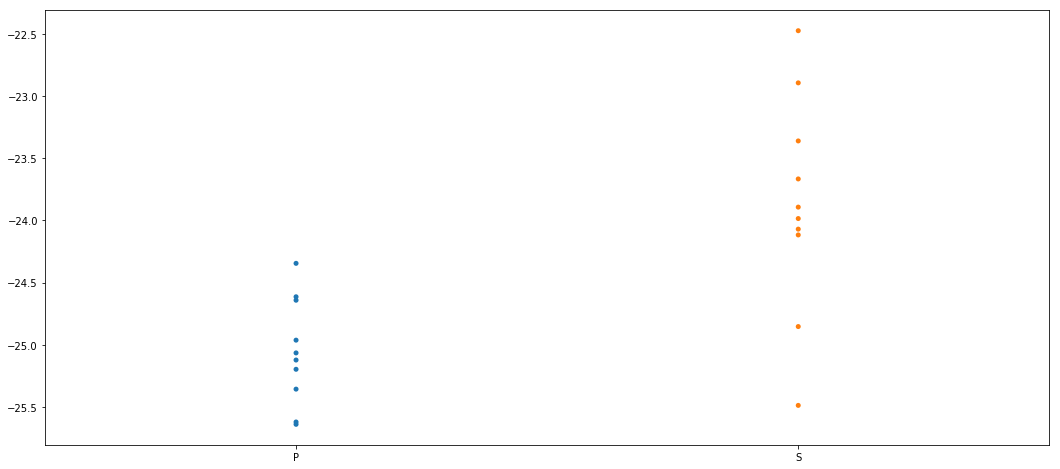

In [178]:
sns.stripplot(x=filenames, y=bandas_alpha_log)

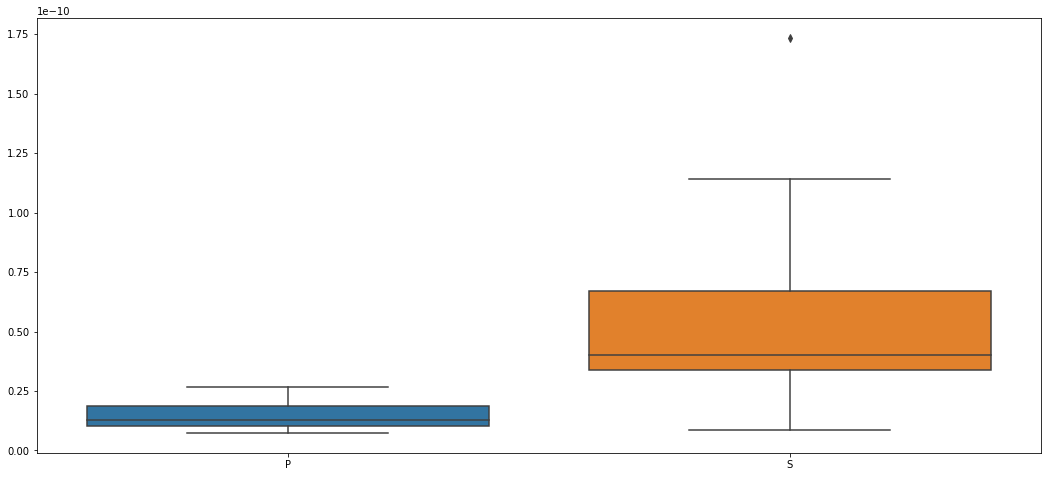

In [176]:
sns.boxplot(x=filenames, y=bandas_alpha)

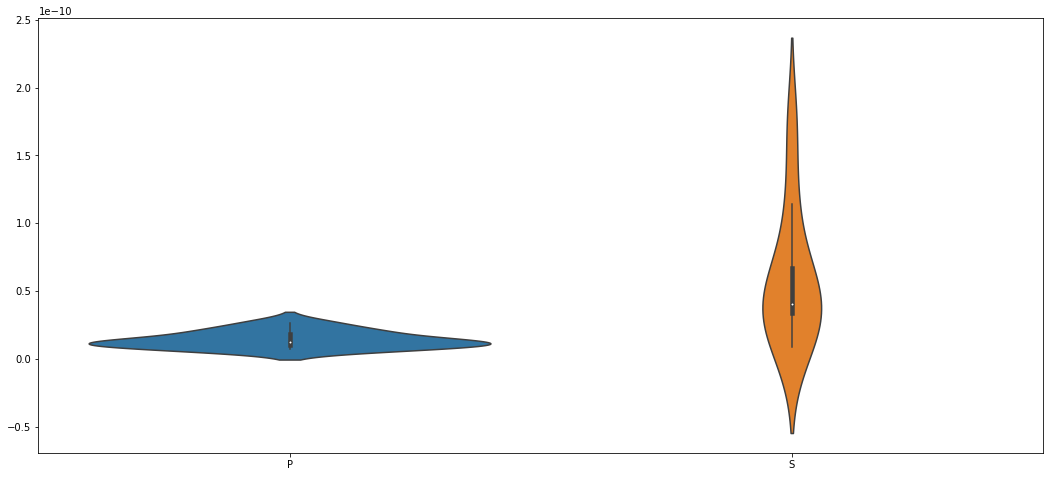

In [175]:
sns.violinplot(x=filenames, y=bandas_alpha)

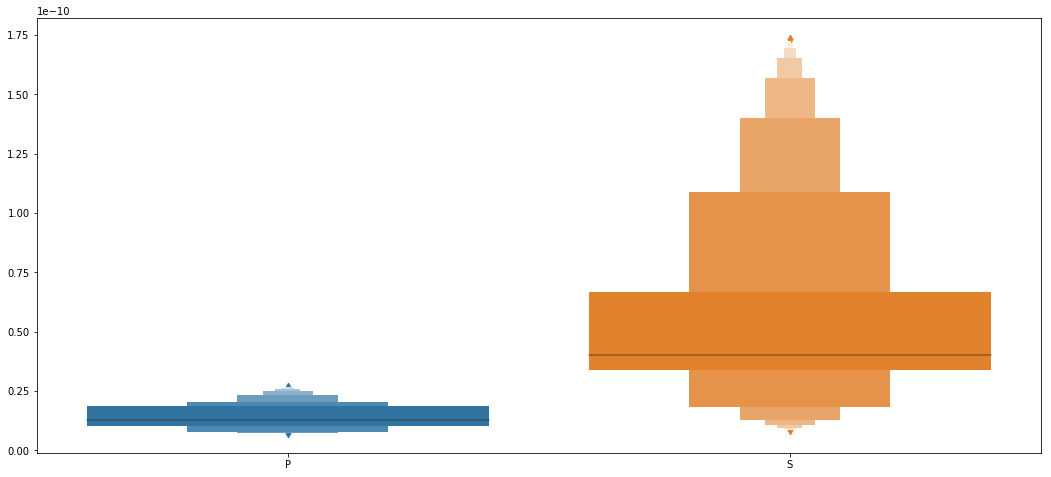

In [179]:
sns.lvplot(x=filenames, y=bandas_alpha)

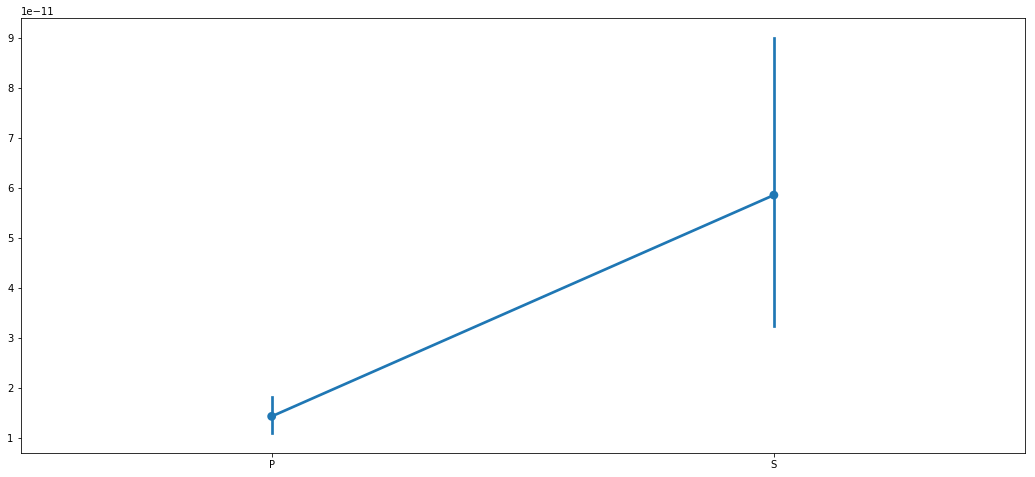

In [180]:
sns.pointplot(x=filenames, y=bandas_alpha)

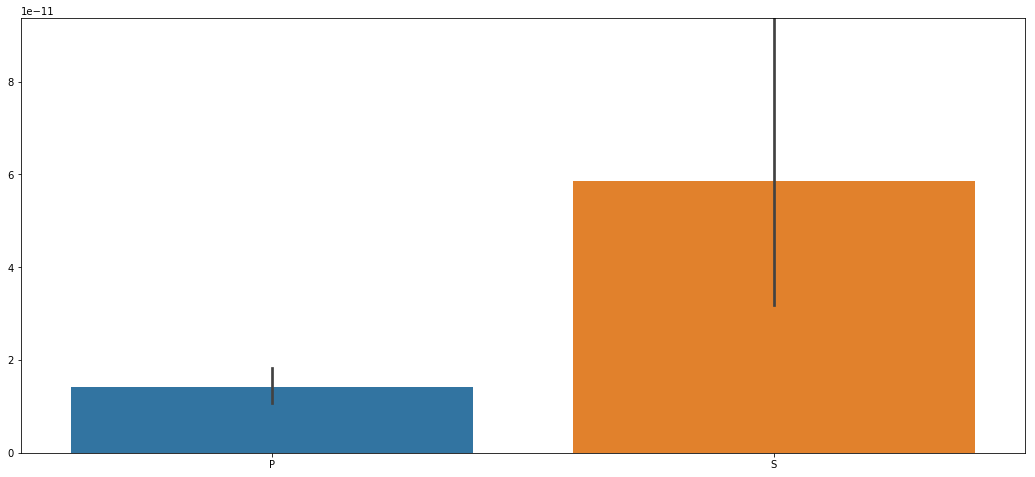

In [181]:
sns.barplot(x=filenames, y=bandas_alpha)

¿Cuál recomendaría para graficar y comparar distribuciones?

Recomendariamos utilizar graficos sobre violin plots. Usar boxplots tiene el riesgo de perder la variacion en la distribucion, si las medidas que el boxplot (cuartil, mediana, etc) usa se mantienen similares a pesar del cambio en los datos crudos. Al utilizar violin plots, se puede ver y comparar la variacion en las distribuciones deseadas, ya que ademas de la medidas de boxplot, violinplot se hace con KDE (Kernel Density Estimation).

d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

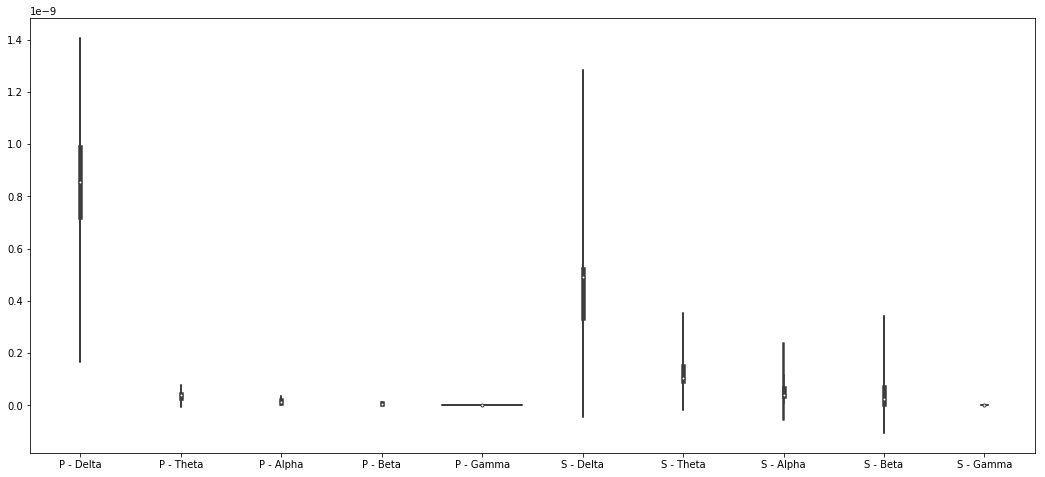

In [202]:
# Agrupamos todos los valores en categoria x bandas ({P|S} * {theta, alpha, beta, gamma, etc})

x, y = [], []
for filename, datapoints in bins_por_sujeto.items():
    letter = get_letter(filename)
    for index, value in enumerate(datapoints):
        try:
            label = letter + ' - ' + nombre_bandas[index]
        except IndexError:
            continue
        else:
            x.append(label)
            y.append(value)
        
sns.violinplot(x=x, y=y)

TODO: t-test

e) Repetir los puntos b) y d) para los valores normalizados.

Al binnear los poderes espectrales por bandas, dividir por la cantidad que cayeron en cada banda
TODO

In [ ]:
# Agrupamos todos los valores en categoria x bandas ({P|S} * {theta, alpha, beta, gamma, etc})

x, y = [], []
for filename, datapoints in bins_por_sujeto.items():
    letter = get_letter(filename)
    for index, value in enumerate(datapoints):
        try:
            label = letter + ' - ' + nombre_bandas[index]
        except IndexError:
            continue
        else:
            x.append(label)
            y.append(value)
        
sns.violinplot(x=x, y=y)

## 2.2 Análisis de información

a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

b) Repetir el punto a) para una medida inter-electrodo.

In [ ]:
print(4)